## Try to replicate SMT

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from tools import *


# Check that MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is enabled!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("cuda is enabled!")



cuda is enabled!
cuda is enabled!


### 1. Generate data from Archimedean spiral

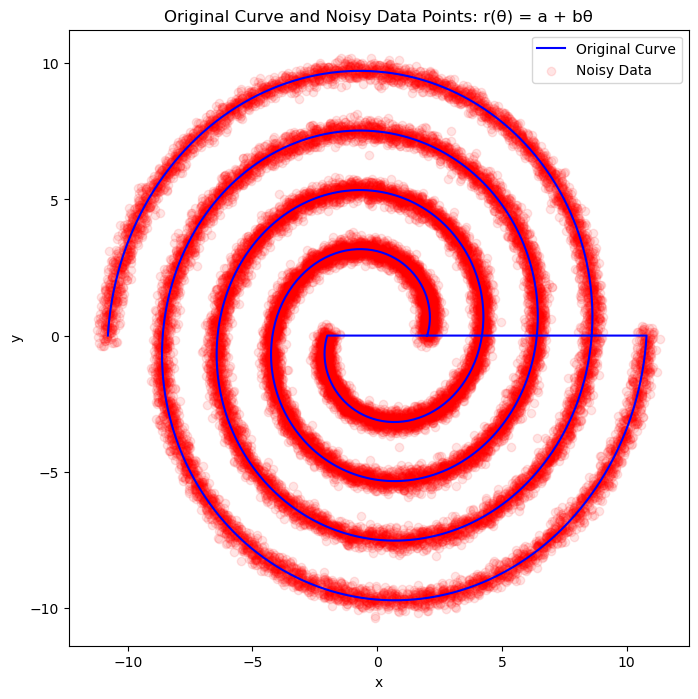

In [2]:
data = GenerateDataset()

## 2. Sparse coding

In [3]:
data_tensor = torch.tensor(data, dtype=torch.float, device = device)

# Create an instance of SparseCoding model
model = SparseCoding(data_size=data_tensor.shape[0], activ_dim=data_tensor.shape[1], basisfunc_num=750, sparsity_level=0)


# Define optimizer for Biasis update
optimizer = optim.Adam([model.Activ, model.Basis], lr=0.01)

# Number of optimization steps
num_epochs = 3000

# Training loop
for epoch in range(num_epochs):

    # Update A
    dist = torch.norm(data_tensor[:, None, :] - model.Basis[None, :, :], p=2, dim=2)
    min_indices = torch.argmin(dist, dim=1)  # Find indices of largest elements in each row
    model.Activ.zero_()
    model.Activ.scatter_(1, min_indices.unsqueeze(1), 1)

    # Update B
    cost = model.loss(data_tensor)
    
    # Zero gradients, perform a backward pass, and update the weights
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Cost = {cost}')

    if cost <= 1e-2:
        print('training ended!')
        break

# After training, you can use the learned dictionary to encode new data
encoded_data = model.Activ @ model.Basis
print("Encoded data shape:", encoded_data.shape)



Epoch [10/3000], Cost = 0.133428156375885
Epoch [20/3000], Cost = 0.09755776077508926
Epoch [30/3000], Cost = 0.07515095174312592
Epoch [40/3000], Cost = 0.06051791459321976
Epoch [50/3000], Cost = 0.051019083708524704
Epoch [60/3000], Cost = 0.04552966356277466
Epoch [70/3000], Cost = 0.04242340475320816
Epoch [80/3000], Cost = 0.04048091918230057
Epoch [90/3000], Cost = 0.039210740476846695
Epoch [100/3000], Cost = 0.03829912468791008
Epoch [110/3000], Cost = 0.037588946521282196
Epoch [120/3000], Cost = 0.03706071525812149
Epoch [130/3000], Cost = 0.03670704737305641
Epoch [140/3000], Cost = 0.03645116463303566
Epoch [150/3000], Cost = 0.036229778081178665
Epoch [160/3000], Cost = 0.0360441654920578
Epoch [170/3000], Cost = 0.03587397560477257
Epoch [180/3000], Cost = 0.03571490943431854
Epoch [190/3000], Cost = 0.03559982776641846
Epoch [200/3000], Cost = 0.03550225868821144
Epoch [210/3000], Cost = 0.03543708100914955
Epoch [220/3000], Cost = 0.03538735955953598
Epoch [230/3000], 

### Plot learnt dictionary and clustered data points

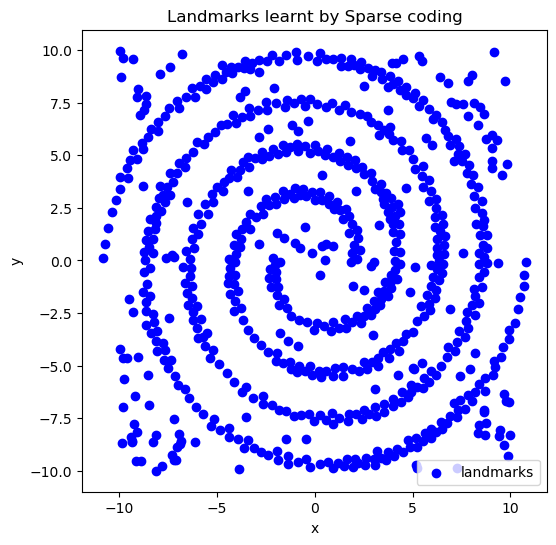

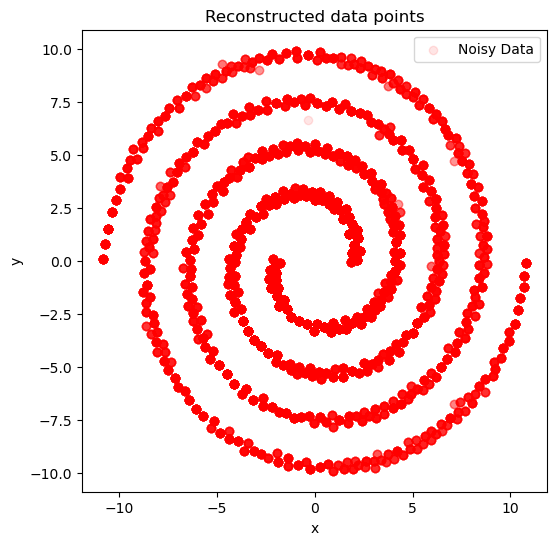

1.0


In [4]:

# return sum_squared_error/num_samples
Bas = model.Basis.detach().cpu()
Act = model.Activ.detach().cpu()

recon = Act @ Bas
# Plotting in polar coordinates

# Original curve label='Original Curve', color='blue')
model.plot_basis()

plt.figure(figsize=[6, 6])

# Noisy data points
ax = plt.subplot(111)
ax.scatter(recon[:, 0], recon[:, 1], label='Noisy Data', color='red', alpha=0.1)

# Setting the title and labels
ax.set_title("Reconstructed data points")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.show()

# Show the plot

print(np.linalg.norm(Act[0,:]))


## 2. Assign similarity (Define D)

### 2.1 K-nearest neighbours in sparse code of data (A)

idx:  17905 / 24000
neighbor idx:  tensor([19505,  7506, 12305])
dist:  tensor([0.0526, 0.0533, 0.0640])
tensor([[-8.7563, -1.6777],
        [-8.8116, -1.6918],
        [-8.8261, -1.5860]])


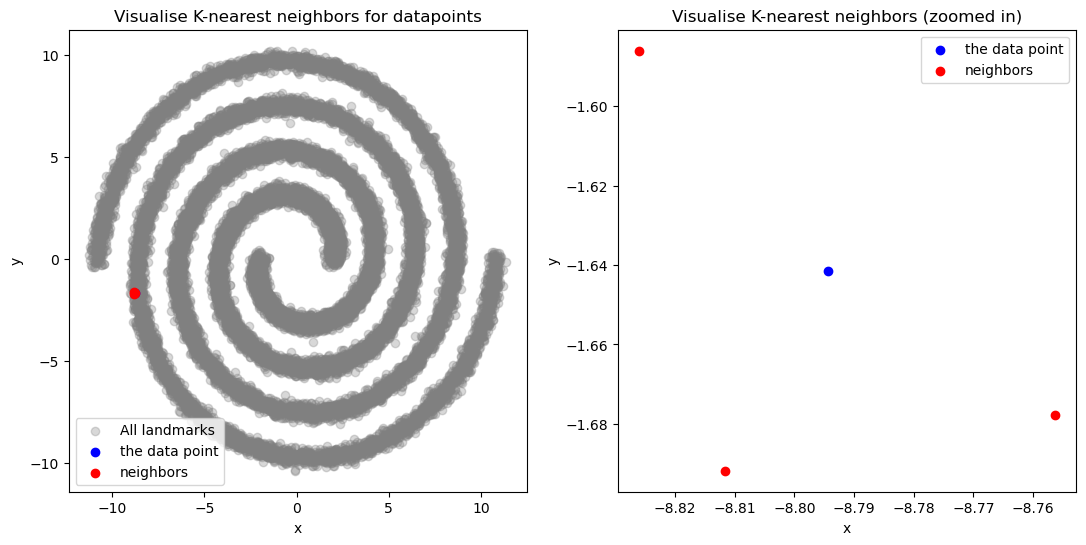

K-nearest neighbors indices of A:
tensor([[ 4800, 15205,  3201],
        [23202, 20801, 13602],
        [20806, 19201, 18403],
        ...,
        [ 4798,  9598, 23198],
        [17598, 13598, 21599],
        [  799, 17599,  4799]])


In [5]:
## Compute K-nearest neighbors for each element in model.Basis

# Compute K-nearest neighbors
neighbors_indices = model.KNN_Data(k=3, data=data_tensor)
print("K-nearest neighbors indices of A:")
print(neighbors_indices)

### 2.2 Construct D from B
Goal: minimising distance between neighbours


### !!Skipped due to dimension issue!!

In [6]:
# a = torch.zeros(7,4,7)
# b = torch.zeros(7,5)

# print((a@b@b.T@a.T).shape)
# # print(a.shape)
# # print(((a@a).shape))

Goal: keep topology by using interpolation (LLE on ~~dictionary~~ dataset elements)

In [32]:
## interpolation Weight matrix
data_tensor = data_tensor.to(torch.float32)
neighbors = data_tensor[neighbors_indices,:] #ss (N,k,2)

print('neighbors shape: ', neighbors.shape)

local_cov = (data_tensor.unsqueeze(1)-neighbors) @ torch.transpose((data_tensor.unsqueeze(1)-neighbors), dim0=1, dim1=2) # (N,k,k)=(N,k,2)@(N,2,k)
local_cov_inv = torch.inverse(local_cov) # (N,k,k)

print(local_cov.shape, ', device =', local_cov.device)
print(local_cov[1]@local_cov_inv[1] - torch.eye(local_cov.shape[1], device=device))

weight = torch.sum(local_cov_inv,dim=1) / torch.sum(local_cov_inv,dim=[1,2]).unsqueeze(1) #(N,k)

print('weight: ', weight.unsqueeze(-1).shape)
recon_dataset = torch.transpose(neighbors,dim0=1,dim1=2) @ weight.unsqueeze(-1) # (N,2,k) @ (N,k,1)
recon_dataset.squeeze_(2)
print(recon_dataset.shape)
print('interpolation error =  ')
print(recon_dataset - data_tensor)

# check sum of weight
print(torch.sum(weight,dim=1))


neighbors shape:  torch.Size([24000, 3, 2])
torch.Size([24000, 3, 3]) , device = cuda:0
tensor([[ 0.3750, -0.0625, -0.0039],
        [-2.7500,  0.6250,  0.0703],
        [ 0.2500, -0.2500, -0.1094]], device='cuda:0')
weight:  torch.Size([24000, 3, 1])
torch.Size([24000, 2])
interpolation error =  
tensor([[ 1.1921e-07,  7.4506e-09],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -7.4506e-09],
        ...,
        [ 4.7684e-06, -1.4901e-07],
        [ 0.0000e+00, -1.4901e-08],
        [ 0.0000e+00,  0.0000e+00]], device='cuda:0')
tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0')


torch.Size([24000, 3])
torch.Size([24000, 3])
Inf:
916
tensor([-inf, inf, inf], device='cuda:0')
tensor([[-1.4922e-07, -9.8366e-09],
        [ 1.6602e-07, -1.9057e-10],
        [ 1.3132e-08,  4.8779e-09],
        ...,
        [-4.7684e-06,  1.4901e-07],
        [ 0.0000e+00,  1.4901e-08],
        [-9.5367e-07, -2.9802e-08]], device='cuda:0')


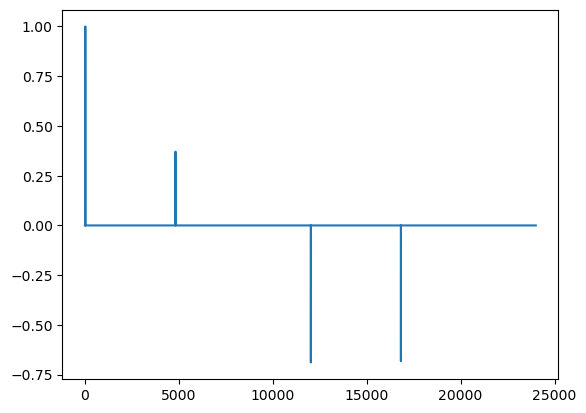

In [33]:
print(neighbors_indices.shape)
print(weight.shape)
Diff = torch.eye(Act.shape[0], device=device) # (N,N)

# Iterate over each row (for each data point)
for i in range(neighbors_indices.size(0)):
    # Select vaelements from Diff based on indices and apply weights
    if torch.isinf(weight[i]).any().item():
        print('Inf:')
        print(i)
        print(weight[i])
    Diff[i, neighbors_indices[i]] -= weight[i]


# Validation 
print(Diff @ data_tensor) # after diff, data should be ~zero
diff = Diff.cpu()[22]
plt.plot(diff)


In [66]:
idx = 916
print(weight[idx])
print(data_tensor[idx])
print('neighbors: ')
print(neighbors[idx])
print()
print(local_cov_inv[idx])

weight_idx = torch.sum(local_cov_inv[idx],dim=0) / torch.sum(local_cov_inv[idx]) #(N,k)

# Sum along dim=0 and then sum again
sum1 = torch.sum(torch.sum(local_cov_inv[idx].cpu(), dim=0))

# Sum without specifying dimension
sum2 = torch.sum(local_cov_inv[idx].cpu())

# Sum without specifying dimension (device version)
sum3 = torch.sum(local_cov_inv[idx])

# Convert to Python floats and print
print(float(sum1))
print(float(sum2))
print(float(sum3))


print(local_cov_inv[idx,1,1])
tensor_np = local_cov_inv[idx,1,1].cpu().numpy()

# Print the full tensor
np.set_printoptions(formatter={'float': '{:0.16f}'.format})
print("Full tensor:", tensor_np)


tensor([-inf, inf, inf], device='cuda:0')
tensor([-3.6213, -2.1527], device='cuda:0')
neighbors: 
tensor([[-3.6525, -2.1476],
        [-3.6525, -2.1472],
        [-3.6460, -2.2874]], device='cuda:0')

tensor([[ 9.5081e+09, -9.4812e+09, -2.7033e+07],
        [-9.4812e+09,  9.4543e+09,  2.6957e+07],
        [-2.7033e+07,  2.6957e+07,  7.6915e+04]], device='cuda:0')
442.8203125
198.0
0.0
tensor(9.4543e+09, device='cuda:0')
Full tensor: 9454293000.0


### 2.3 Solve generalised eigenvalue problem

In [10]:
# Check for NaN values
nan_mask = torch.isnan(Diff)
print("Contains NaN:", nan_mask.any().item())

# Check for Inf values
inf_mask = torch.isinf(Diff)
print("Contains Inf:", inf_mask.any().item())


Contains NaN: False
Contains Inf: True


In [11]:
d = 10 # dimension of final embedding space

if device==torch.device("mps"):
    # some operation are not supported on mps device
    Diff = Diff.cpu()

print(Diff.shape)

Diff_eigenvalues, Diff_eigenvectors = torch.linalg.eig(Diff)

Diff_eigenvalues = Diff_eigenvalues.to(torch.float32)
Diff_eigenvectors = Diff_eigenvectors.to(torch.float32)

plt.figure()
plt.plot(Diff_eigenvalues)
plt.title('eigenvalues')
plt.show()


sorted_indices = torch.argsort(Diff_eigenvalues)
sorted_eigenvalues = Diff_eigenvalues[sorted_indices]
sorted_eigenvectors = Diff_eigenvectors[:, sorted_indices]

plt.figure()
plt.plot(sorted_eigenvalues)
plt.title('eigenvalues (sorted)')
plt.show()


print(torch.sum(sorted_eigenvalues)) ## TODO: Why????????????

torch.Size([24000, 24000])


RuntimeError: torch.linalg.eig: input tensor should not contain infs or NaNs.

In [ ]:
## Now find P

A = model.Activ.detach().cpu()

#  Compute eigenvalue decomposition of A
ATA_eigenvalues,ATA_eigenvectors = torch.linalg.eigh(A.T@A)

# Square root of eigenvalues
ATA_sqrt_eigenvalues = torch.sqrt(ATA_eigenvalues)

# Reconstruct square root of A from eigenvalues and eigenvectors
sqrt_ATA = ATA_eigenvectors @ torch.diag(ATA_sqrt_eigenvalues) @ ATA_eigenvectors.t()
inv_sqrt_ATA = torch.pinverse(sqrt_ATA)

raw_P = inv_sqrt_ATA @ sorted_eigenvectors[:,0:d]

# Normalize each column 
raw_P = raw_P / torch.norm(raw_P, dim=0) 


P = raw_P.T @ inv_sqrt_ATA / inv_sqrt_ATA.size(0)**0.5
print(P.shape)

print(P)

### 2.4 Visualise P

In [ ]:
# Example data
idx = 3
fig, [ax, ax1] = plt.subplots(figsize=[12,6],nrows=1, ncols=2)

colors = P.cpu()[idx]
colors = (colors - torch.min(colors)) / (torch.max(colors) - torch.min(colors))

cmap = 'viridis'  # Example colormap

# plot dictionary elements using first row of P
ax.scatter(Bas[:, 0], Bas[:, 1], label='All landmarks', c=colors, cmap=cmap)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Colormap')
plt.show()

### 2.5 Embedding space distance visualization

In [ ]:
landmark_idx = 61
orig_sigma = 3
embed_sigma = 2e-8

def gaussian(dist, sigma):
    return torch.exp(-torch.pow(dist, 2) / (2 * sigma**2))

## Euc distance
orig_dist = torch.cdist(Bas,Bas[landmark_idx,:].unsqueeze(0),p=2)
Gaussian_orig_dist = gaussian(orig_dist,sigma=orig_sigma)
print(orig_dist.shape)

## Embedding space dist
embed_dist = torch.cdist(P.T,P.T[landmark_idx,:].unsqueeze(0),p=2)
print(embed_dist)
Gaussian_embed_dist = gaussian(embed_dist,sigma=embed_sigma)

fig, [ax, ax1] = plt.subplots(figsize=[12,6],nrows=1, ncols=2)

map = [(1, 1, 1, 0), (1, 0.5, 0, 1)]  # Start with transparent (white) and end with orange
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', map)

# plot dictionary elements using first row of P


ax.scatter(Bas[:, 0], Bas[:, 1], label='All landmarks', c=Gaussian_orig_dist, cmap=cmap,vmin=1e-2, vmax=1)
ax1.scatter(Bas[:, 0], Bas[:, 1], label='All landmarks', c=Gaussian_embed_dist, cmap=cmap,vmin=1e-2, vmax=1)

ax.scatter(Bas[landmark_idx, 0], Bas[landmark_idx, 1], label='the landmark', c='blue')
ax1.scatter(Bas[landmark_idx, 0], Bas[landmark_idx, 1], label='the landmark', c='blue')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Colormap')
plt.show()
